# Modelling spreading of enfectious diseases
Very much an experiment inspirered by https://triplebyte.com/blog/modeling-infectious-diseases    

In [14]:
import pandas as pd
from ipywidgets import interact,Dropdown,Checkbox,Layout,FloatSlider

from modelsandbox import newmodel
import modelclass as mc
import modelmanipulation as mp 
from modeljupyter import inputwidget

In [15]:
def dist_erlang(length,a=1,rate=1):
    aa=int(a)
    weights_before =  np.array([erlang.cdf(x+1., aa,rate)-erlang.cdf(x, aa,rate) for x in range(length)])
    weights = weights_before/weights_before.sum()
    sweights =pd.Series(weights)
    return sweights

def lag_erlang(values,a=1,rate=1):
    weights=dist_erlang(len(values),a,rate)
    weighted = (values*weights)
    print(weighted)
    return weighted.sum()

def lag_manual(values,weights,debug=0):
    weights_s = pd.Series(weights)
    weights_normalized = weights_s/weights_s.sum()
    values_s  = pd.Series(values)
    weighted  = (values_s*weights_normalized).fillna(0)
    result = weighted.sum()
    if int(debug):
        weights_org = pd.Series(weights)
        temp = pd.concat([weights_s, weights_normalized,values_s,weighted],axis=1)
        temp.columns = ['weights_org','weights normallized','Values','weighted values']
        time = pd.Series([int(i) for i in temp.index])
        average_lag = (pd.Series(time)*weights_normalized).fillna(0).sum()
        print(temp)
        print(f'Result       {result:15.5f}')
        print(f'Average lag  {average_lag:15.5f}')
        # print(time)
    return result 


In [ ]:
DAYS = 200
day_list = f'day_list = day : {" ".join([str(i) for i in range(DAYS)])}'
day_list

In [16]:
DAYS = 200
day_list = f'LIST day_list = day: {" ".join(["DAY_"+str(i) for i in range(DAYS)])}'
day_list

'LIST day_list = day: DAY_0 DAY_1 DAY_2 DAY_3 DAY_4 DAY_5 DAY_6 DAY_7 DAY_8 DAY_9 DAY_10 DAY_11 DAY_12 DAY_13 DAY_14 DAY_15 DAY_16 DAY_17 DAY_18 DAY_19 DAY_20 DAY_21 DAY_22 DAY_23 DAY_24 DAY_25 DAY_26 DAY_27 DAY_28 DAY_29 DAY_30 DAY_31 DAY_32 DAY_33 DAY_34 DAY_35 DAY_36 DAY_37 DAY_38 DAY_39 DAY_40 DAY_41 DAY_42 DAY_43 DAY_44 DAY_45 DAY_46 DAY_47 DAY_48 DAY_49 DAY_50 DAY_51 DAY_52 DAY_53 DAY_54 DAY_55 DAY_56 DAY_57 DAY_58 DAY_59 DAY_60 DAY_61 DAY_62 DAY_63 DAY_64 DAY_65 DAY_66 DAY_67 DAY_68 DAY_69 DAY_70 DAY_71 DAY_72 DAY_73 DAY_74 DAY_75 DAY_76 DAY_77 DAY_78 DAY_79 DAY_80 DAY_81 DAY_82 DAY_83 DAY_84 DAY_85 DAY_86 DAY_87 DAY_88 DAY_89 DAY_90 DAY_91 DAY_92 DAY_93 DAY_94 DAY_95 DAY_96 DAY_97 DAY_98 DAY_99 DAY_100 DAY_101 DAY_102 DAY_103 DAY_104 DAY_105 DAY_106 DAY_107 DAY_108 DAY_109 DAY_110 DAY_111 DAY_112 DAY_113 DAY_114 DAY_115 DAY_116 DAY_117 DAY_118 DAY_119 DAY_120 DAY_121 DAY_122 DAY_123 DAY_124 DAY_125 DAY_126 DAY_127 DAY_128 DAY_129 DAY_130 DAY_131 DAY_132 DAY_133 DAY_134 DAY_135 

In [17]:
# Specify Model 
rcorona = '''\
             infection_rate        = rate_contact * probability_transmision * infectious(-1) / population(-1) 
             new_exposed           = infection_rate * susceptible
             diff(exposed)         = new_exposed - new_infectious + exo_exposed

             new_infectious        = lag_manual(lag_array(4, exposed),(0,0,10,4)
             diff(infectious)      = new_infectious - diff(recovered) - dead

             diff(susceptible)     = -new_exposed  

             diff(recovered)       = recovery_rate * infectious(-1)

             dead                  = dead_rate * infectious(-1)
             diff(alldead)         = dead
             diff(population)      = -dead
             
'''


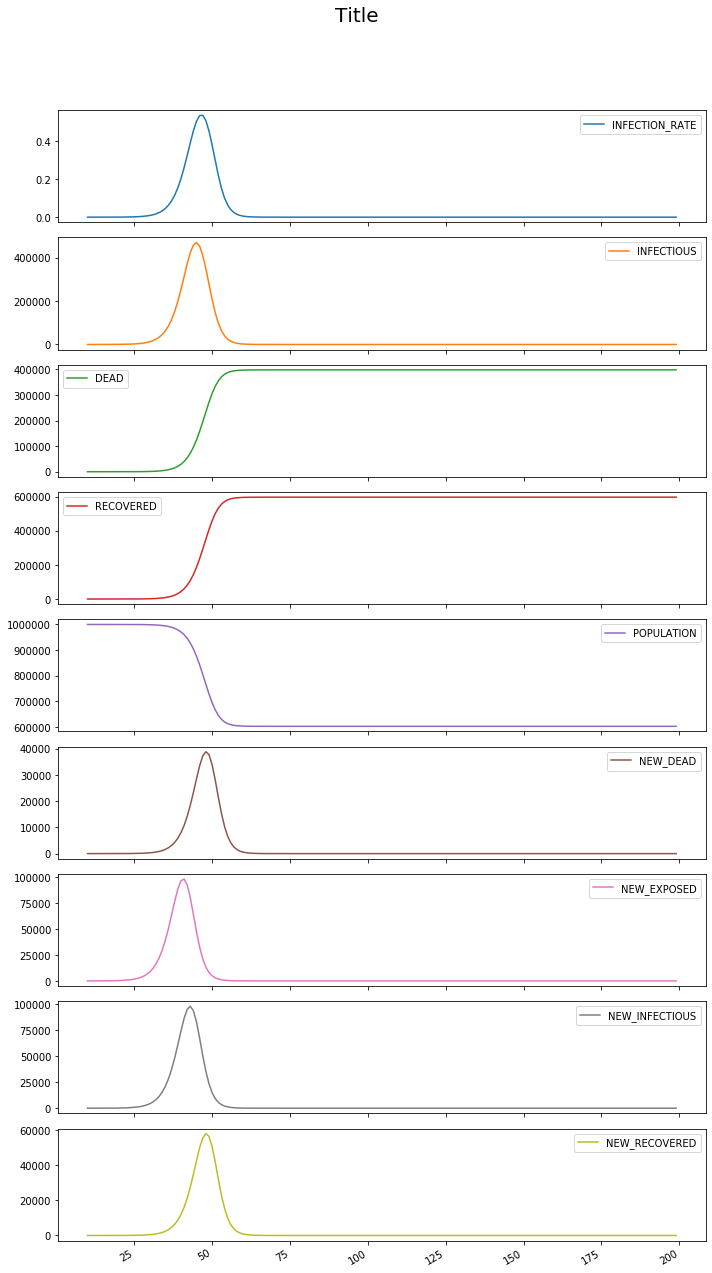

In [98]:
DAYS = 200

# Specify Model 
rcorona = '''\
            new_exposed           = infection_rate * susceptible + exo_exposed
            new_infectious        = lag_manual(lag_array(4, new_exposed),(0,0,80,20))
            
            new_recovered         =  0.6 *lag_manual(lag_array(10, new_infectious),(0,0,0,0,0,80,20))
            new_dead              =  0.4 *lag_manual(lag_array(10, new_infectious),(0,0,0,0,0,80,20))
            diff(infectious)      = new_infectious - new_recovered - new_dead
            
            diff(susceptible)     = -new_exposed  
            diff(dead)            = new_dead
            diff(recovered)       = new_recovered
            diff(population)      = -new_dead

            infection_rate       = min(rate_contact * probability_transmision * infectious(-1) / population(-1),1.0) 
             
'''

# create a model instance 
f1corona = mp.explode(rcorona)
fcorona = mp.lagarray_unroll(f1corona,funks=[lag_manual])
mcorona = newmodel(fcorona,funks=[lag_manual])
# mcorona.drawmodel(lag=1,size=(2,2))

basedf = pd.DataFrame(index=range(DAYS))    # make an empty dataframe with DAYS rows
grunddf = mc.insertModelVar(basedf,mcorona) # fill dataframe with zeros 
grunddf.loc[:,'POPULATION']= 1000000
grunddf['SUSCEPTIBLE'] = grunddf['POPULATION']
grunddf.loc[12,'EXO_EXPOSED']= 100

grunddf.loc[:,'RATE_CONTACT'] = 10
grunddf.loc[:,'PROBABILITY_TRANSMISION'] = 0.1

res1 = mcorona(grunddf,antal=20,first_test=20,silent=1)

mcorona['*'].df.style.format('{0:,.0f}')
mcorona['in* dead rec* pop* new*'].plot(colrow=1,sharey=0);

In [97]:
mcorona['pop*'].df.style.format('{0:,.0f}')


,POPULATION
10,"1,000,000"
11,"1,000,000"
12,"1,000,000"
13,"1,000,000"
14,"1,000,000"
15,"1,000,000"
16,"1,000,000"
17,"1,000,000"
18,"1,000,000"
19,"999,974"


In [56]:
print(mcorona.equations)

FRML <> NEW_EXPOSED           = INFECTION_RATE * SUSCEPTIBLE + EXO_EXPOSED $
FRML <> NEW_INFECTIOUS        = LAG_MANUAL((( NEW_EXPOSED,NEW_EXPOSED(-1),NEW_EXPOSED(-2),NEW_EXPOSED(-3),NEW_EXPOSED(-4))),(0,0,80,20)) $
FRML <> INFECTIOUS=INFECTIOUS(-1)+(NEW_INFECTIOUS - ((RECOVERED)-(RECOVERED(-1))) - ((DEAD)-(DEAD(-1))))$
FRML <> SUSCEPTIBLE=SUSCEPTIBLE(-1)+(-NEW_EXPOSED)$
FRML <> NEW_RECOVERED         =  0.6 *LAG_MANUAL((( NEW_EXPOSED,NEW_EXPOSED(-1),NEW_EXPOSED(-2),NEW_EXPOSED(-3),NEW_EXPOSED(-4),NEW_EXPOSED(-5),NEW_EXPOSED(-6),NEW_EXPOSED(-7),NEW_EXPOSED(-8),NEW_EXPOSED(-9),NEW_EXPOSED(-10))),(0,0,0,0,0,80,20)) $
FRML <> NEW_DEAD              =  0.4 *LAG_MANUAL((( NEW_EXPOSED,NEW_EXPOSED(-1),NEW_EXPOSED(-2),NEW_EXPOSED(-3),NEW_EXPOSED(-4),NEW_EXPOSED(-5),NEW_EXPOSED(-6),NEW_EXPOSED(-7),NEW_EXPOSED(-8),NEW_EXPOSED(-9),NEW_EXPOSED(-10))),(0,0,0,0,0,80,20)) $
FRML <> DEAD=DEAD(-1)+(NEW_DEAD)$
FRML <> RECOVERED=RECOVERED(-1)+(NEW_RECOVERED)$
FRML <> POPULATION=POPULATION(-1)+(-DEAD)$
FRML

In [43]:
basedf = pd.DataFrame(index=range(DAYS))    # make an empty dataframe with DAYS rows
grunddf = mc.insertModelVar(basedf,mcorona) # fill dataframe with zeros 
grunddf.loc[:,'POPULATION']= 1000000
grunddf['SUSCEPTIBLE'] = grunddf['POPULATION']
grunddf.loc[5,'EXO_EXPOSED']= 100

res1 = mcorona(grunddf,4,9,antal=2,first_test=2,silent=1)

In [13]:
cow = inputwidget(mcorona,grunddf,modelopt={'silent':1},
                  slidedef = {
                     'Number of infected t=1'     :{'var' : 'EXO_EXPOSED','min' : 0.0, 'max' : 1000, 'value' : 0.0,'step':10,'op':'+impulse'},
                     'Rate of contact'            :{'var' : 'RATE_CONTACT','min' : 0.0, 'max' : 100, 'value' : 1,'step':1},
                     'Probability of transmission':{'var' : 'PROBABILITY_TRANSMISION','min' : 0.0, 'max' : 1.0, 'value' : 0.2},
                     'Daily incuberation rate'    :{'var' : 'INCUBATION_RATE','min' : 0.0, 'max' : 1.0, 'value' : 0.3},
                     'Daily death rate'           :{'var' : 'DEAD_RATE','min' : 0.0, 'max' : 1.0, 'value' : 0.2},
                     'Daily recovery rate'        :{'var' : 'RECOVERY_RATE','min' : 0.0, 'max' : 1.0, 'value' : 0.2}
                             },
                 varpat='#endo')

display(cow)